In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
%cd gdrive
%cd MyDrive/Data
%cd deep_learning/hw1/CODE_ASSIGNMENT/code_masters

/content/gdrive
/content/gdrive/MyDrive/Data
/content/gdrive/MyDrive/Data/deep_learning/hw1/CODE_ASSIGNMENT/code_masters


In [3]:
import random
import numpy as np
from matplotlib import pyplot as plt
from data_process import get_CIFAR10_data
from scipy.spatial import distance
%matplotlib inline
from save_submission import output_submission_csv

# Loading CIFAR-10

In the following cells we determine the number of images for each split and load the images.
<br /> 
TRAIN_IMAGES + VAL_IMAGES = (0, 50000]
, TEST_IMAGES = 10000

In [4]:
# You can change these numbers for experimentation
# For submission we will use the default values 
TRAIN_IMAGES = 40000
VAL_IMAGES = 10000

In [5]:
data = get_CIFAR10_data(TRAIN_IMAGES, VAL_IMAGES)
X_train_CIFAR, y_train_CIFAR = data['X_train'], data['y_train']
X_val_CIFAR, y_val_CIFAR = data['X_val'], data['y_val']
X_test_CIFAR, y_test_CIFAR = data['X_test'], data['y_test']
n_class_CIFAR = len(np.unique(y_test_CIFAR))

Convert the sets of images from dimensions of **(N, 3, 32, 32) -> (N, 3072)** where N is the number of images so that each **3x32x32** image is represented by a single vector.

In [6]:
X_train_CIFAR = np.reshape(X_train_CIFAR, (X_train_CIFAR.shape[0], -1))
X_val_CIFAR = np.reshape(X_val_CIFAR, (X_val_CIFAR.shape[0], -1))
X_test_CIFAR = np.reshape(X_test_CIFAR, (X_test_CIFAR.shape[0], -1))

#Affine transform
Adding a constant component to each example **(N, 3072) -> (N, 3073)**

In [7]:
X_train_CIFAR = np.append(X_train_CIFAR, np.ones((X_train_CIFAR.shape[0],1)), axis=1)
X_val_CIFAR = np.append(X_val_CIFAR, np.ones((X_val_CIFAR.shape[0],1)), axis=1)
X_test_CIFAR = np.append(X_test_CIFAR, np.ones((X_test_CIFAR.shape[0],1)), axis=1)

# Perceptron

Perceptron has 2 hyperparameters that you can experiment with:
- **Learning rate** - controls how much we change the current weights of the classifier during each update. We set it at a default value of 0.5, but you should experiment with different values. We recommend changing the learning rate by factors of 10 and observing how the performance of the classifier changes. You should also try adding a **decay** which slowly reduces the learning rate over each epoch.
- **Number of Epochs** - An epoch is a complete iterative pass over all of the data in the dataset. During an epoch we predict a label using the classifier and then update the weights of the classifier according the perceptron update rule for each sample in the training set. You should try different values for the number of training epochs and report your results.

You will implement the Perceptron classifier in the **models/Perceptron.py**

The following code: 
- Creates an instance of the Perceptron classifier class 
- The train function of the Perceptron class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy


# Model Perceptron

In [8]:
from tqdm.notebook import tqdm #progress bar

class Perceptron:
    #import numpy as np
    def __init__(self, n_class: int, lr: float, epochs: int, decay_type = 'exp'):
        """Initialize a new classifier.
        Parameters:
            n_class: the number of classes
            lr: the learning rate
            epochs: the number of epochs to train for
        """
        if decay_type in ['exp', 'exponential']:
            def decay(t):
                p0 = lr
                k = 1/self.epochs
                return p0 * np.exp(-k*t)
        elif decay_type in ['lin','linear']:
            self.linsp = np.linspace(lr, 0, epochs)
            def decay(t):
                return self.linsp[t]
        elif decay_type in ['sin', 'sine']:
            def decay(t):
                return lr/8 * np.sin(8*t) + lr
        else:
            def decay(t):
                return lr

        # def decay(t):
        #     return lr

        self.w = None 
        self.lr = decay
        self.epochs = epochs
        self.n_class = n_class

    def train_GD(self, X_train: np.ndarray, y_train: np.ndarray):
        """Train the classifier.
        Use the perceptron update rule as introduced in Lecture 3.
        Parameters:
            X_train: a number array of shape (N, D) containing training data;
                N examples with D dimensions
            y_train: a numpy array of shape (N,) containing training labels
        """
        N, D = X_train.shape
        self.w = np.random.randn(self.n_class, D)

        
        ###### YOUR CODE STARTS HERE ######
        
        '''
        Since we're using one-vs-all perceptrons for each class
        Then our update label can be +1 if = and -1 if not equal
        Then we can still keep the liXi term encoding direction of 
        update

        '''

        stats = {'lr':[],'acc':[]}
        with tqdm(total=self.epochs) as pbar:
            for e in range(self.epochs):
                miss = []
                indx = list(range(N))
                np.random.shuffle(indx)

                for i in indx:
                    x,y = X_train[i], y_train[i]
                    pred = np.argmax(self.w @ x)
                    if pred != y:
                        miss.append(i)
                        
                update = 0
                for i in miss:
                    x,y = X_train[i], y_train[i]
                    update += x

                self.w[y] += self.lr(e) * update
                self.w[pred] -= self.lr(e) * update

                self.w[y] /= np.linalg.norm(self.w[y])
                self.w[pred] /= np.linalg.norm(self.w[pred])

                stats['lr'].append(self.lr(e))
                stats['acc'].append(1-len(miss)/N)
                pbar.update(1)
        return stats
        
        ###### YOUR CODE ENDS HERE ######
        pass

    def train_SGD(self, X_train: np.ndarray, y_train: np.ndarray):
        """Train the classifier.
        Use the perceptron update rule as introduced in Lecture 3.
        Parameters:
            X_train: a number array of shape (N, D) containing training data;
                N examples with D dimensions
            y_train: a numpy array of shape (N,) containing training labels
        """
        N, D = X_train.shape
        self.w = np.random.randn(self.n_class, D)

        
        ###### YOUR CODE STARTS HERE ######
        
        '''
        Since we're using one-vs-all perceptrons for each class
        Then our update label can be +1 if = and -1 if not equal
        Then we can still keep the liXi term encoding direction of 
        update

        '''

        stats = {'lr':[],'acc':[]}

        with tqdm(total=self.epochs) as pbar:

            for e in range(self.epochs):
                indx = list(range(N))
                np.random.shuffle(indx)
                miss = 0
                for i in indx:
                    x,y = X_train[i], y_train[i]
                    pred = np.argmax(self.w @ x)
                    if pred != y:
                        miss += 1
                        self.w[y] += self.lr(e) * x
                        self.w[pred] -= self.lr(e) * x

                        self.w[y] /= np.linalg.norm(self.w[y])
                        self.w[pred] /= np.linalg.norm(self.w[pred])

                stats['lr'].append(self.lr(e))
                stats['acc'].append(1-miss/N)
                pbar.update(1)
        return stats
        
        ###### YOUR CODE ENDS HERE ######
        pass

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        self.train_SGD(X_train, y_train)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Use the trained weights to predict labels for test data points.
        Parameters:
            X_test: a numpy array of shape (N, D) containing testing data;
                N examples with D dimensions
        Returns:
            predicted labels for the data in X_test; a 1-dimensional array of
                length N, where each element is an integer giving the predicted
                class.
        """
        N, D = X_test.shape
        y_test = np.zeros(N)
        ###### YOUR CODE STARTS HERE ######
        for i,x in enumerate(X_test):
            pred = self.w @ x
            y_test[i] = np.argmax(pred)
        ###### YOUR CODE ENDS HERE ######
        return y_test
        
'''

    def train_sgd(self, X_train: np.ndarray, y_train: np.ndarray):
        """Train the classifier.
        Use the perceptron update rule as introduced in Lecture 3.
        Parameters:
            X_train: a number array of shape (N, D) containing training data;
                N examples with D dimensions
            y_train: a numpy array of shape (N,) containing training labels
        """
        N, D = X_train.shape
        self.w = np.random.randn(self.n_class, D)

        ###### YOUR CODE STARTS HERE ######

        '/''
        Plan:
            We have n_class classes
            So let's have a param vector w for each class. 
            Let's collect all the w's into a (n_class x D matrix)
            Then when we multiply W by x (which is a D-vector) 
                we have a prediction for each class 
            Let's call the n_class-vector of predictions R

            Regardless of what activation function we use, we want a higher
            score to mean a higher certainty of the class. So we can just
            take the argmax of R to be the class prediction. Saying the network
            is most certain that x belongs to this class in R, since it gave
            it the highest score. 

            If we missclasify, then we should 
            add lr * x to the w for the correct class 
            subtract lr * x from the w for the predicted class. 

        '/''
        for e in range(self.epochs):
            print(e, end=', ')
            idx = list(range(N))
            np.random.shuffle(idx)
            miss = False
            for t, i in enumerate(idx):
                x,y = X_train[i], y_train[i]
                pred = np.argmax(self.w @ x)
                if pred != y:
                    miss = True
                    self.w[y] += self.lr(t) * x
                    self.w[pred] -= self.lr(t) * x
            if not miss: return #you miss every shot you don't take
        return
        ###### YOUR CODE ENDS HERE ######
        pass   

'''
;

''

## Train Perceptron on CIFAR

In [18]:
def get_acc(pred, labels):
    assert len(pred) == len(labels)
    correct = 0
    total = len(labels)
    for i in range(total):
        if pred[i] == labels[i]:
            correct += 1
    return correct/total

def test(lr, n_epochs, decay = 'exp'):
    percept_CIFAR = Perceptron(n_class_CIFAR, lr, n_epochs, decay_type=decay)
    stats = percept_CIFAR.train(X_train_CIFAR, y_train_CIFAR)
    pred_percept = percept_CIFAR.predict(X_train_CIFAR)

    acc = get_acc(pred_percept, y_train_CIFAR)
    print('\nAccuracy: %f' % (acc))

    plt.plot(stats['lr'], label = 'Learning rate')
    plt.plot(stats['acc'], label = 'Accuracy')
   
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return acc

def test_SGD(lr, n_epochs, decay = 'exp'):
    percept_CIFAR = Perceptron(n_class_CIFAR, lr, n_epochs, decay_type=decay)
    stats = percept_CIFAR.train_SGD(X_train_CIFAR, y_train_CIFAR)
    pred_percept = percept_CIFAR.predict(X_train_CIFAR)

    acc = get_acc(pred_percept, y_train_CIFAR)
    print('\nAccuracy: %f' % (acc))

    plt.plot(stats['lr'], label = 'Learning rate')
    plt.plot(stats['acc'], label = 'Accuracy')
   
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return percept_CIFAR, acc


In [ ]:
percept_CIFAR, _ = test_SGD(0.05, 10, 'lin')

In [ ]:
percept_CIFAR_2 = test_SGD(0.05, 10, 'lin')

In [ ]:
percept_CIFAR_2 = percept_CIFAR_2[0]

### Validate Perceptron on CIFAR

In [ ]:
def test_overfit():
    results = {}
    for i in [10,100, 200, 500]:
        p, _ = test_SGD(0.05, i, 'linear')
        pred = p.predict(X_val_CIFAR)
        acc = get_acc(pred, y_val_CIFAR)
        print('acc:', acc)
        results[i] = acc
    return results

In [ ]:
p,a = test_SGD(0.05, 20, 'const')

In [ ]:
pred_percept = p.predict(X_val_CIFAR)
print('The validation accuracy is given by: %f' % (get_acc(pred_percept, y_val_CIFAR)))

In [ ]:
def random_sgd(n=2):
    maxacc = 0
    maxp = None
    for i in range(n):
        for lr in [1, 0.7, 0.5, 0.1, 0.05]:
            print(f"{i}: lr = {lr}")
            p, a = test_SGD(lr = lr, n_epochs = 20, decay = 'linear')
            pred_percept = p.predict(X_val_CIFAR)
            acc = get_acc(pred_percept, y_val_CIFAR)
            if acc > maxacc:
                maxacc = acc
                maxp = p
            print(f'The validation accuracy is given by: {acc}.') 
    return maxacc, maxp

  0%|          | 0/20 [00:00<?, ?it/s]


Accuracy: 0.427675


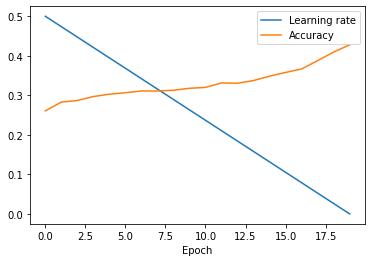

In [ ]:
p,a = test_SGD(0.5, 20, decay = 'linear')

##Observations

I tried different learning rate decay types (exponential, linear, sine wave, constant) and different rates, and found best results with linear decay and lr = 0.5
My perceptron is overfitting the training data, getting asymptotically closer to 50% accuracy over 500 epochs, but the validation accuracy does not grow past ~30%. 



In [ ]:
test_overfit() #found that I was overfitting.

In [ ]:
pred_percept = p.predict(X_val_CIFAR)
print('The validation accuracy is given by: %f' % (get_acc(pred_percept, y_val_CIFAR)))

The validation accuracy is given by: 0.299100


In [ ]:
pred_percept = percept_CIFAR_2.predict(X_val_CIFAR)
print('The validation accuracy is given by: %f' % (get_acc(pred_percept, y_val_CIFAR)))

### Test Perceptron on CIFAR

In [ ]:
pred_percept = maxp.predict(X_test_CIFAR)

In [ ]:
pred_percept = p.predict(X_test_CIFAR)
print('The testing accuracy is given by: %f' % (get_acc(pred_percept, y_test_CIFAR)))

The testing accuracy is given by: 0.303600


In [ ]:
pred_percept = percept_CIFAR_2.predict(X_test_CIFAR)
print('The testing accuracy is given by: %f' % (get_acc(pred_percept, y_test_CIFAR)))

In [ ]:
output_submission_csv('output/Perceptron_submission_CIFAR.csv', p.predict(X_test_CIFAR))

In [ ]:
output_submission_csv('output/Logistic_submission_CIFAR.csv', percept_CIFAR.predict(X_test_CIFAR))

# Logistic Classifier

The Logistic Classifier has 2 hyperparameters that you can experiment with:
- **Learning rate** - similar to as defined above in Perceptron, this parameter scales by how much the weights are changed according to the calculated gradient update. 
- **Number of Epochs** - As described for perceptron.



You will implement the Logistic Classifier in the **models/Logistic.py**

The following code: 
- Creates an instance of the Logistic classifier class 
- The train function of the Logistic class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy

In [44]:
"""Logistic regression model."""

import numpy as np
import math


class Logistic:
    def __init__(self, lr: float, epochs: int, n_class: int, decay_type: str):
        """Initialize a new classifier.
        Parameters:
            lr: the learning rate
            epochs: the number of epochs to train for
        """
        if decay_type in ['exp', 'exponential']:
            def decay(t):
                p0 = lr
                k = 1/self.epochs
                return p0 * np.exp(-k*t)
        elif decay_type in ['lin','linear']:
            self.linsp = np.linspace(lr, lr/10, epochs)
            def decay(t):
                return self.linsp[t]
        elif decay_type in ['sin', 'sine']:
            def decay(t):
                return lr/8 * np.sin(8*t) + lr
        else:
            def decay(t):
                return lr

        self.w = None
        self.lr = decay
        self.epochs = epochs 
        self.threshold = 0.5
        self.n_class = n_class

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Sigmoid function.
        Parameters:
            z: the input
        Returns:
            the sigmoid of the input
        """
        ##### YOUR CODE STARTS HERE #####
        ret = 1/(1+np.exp(-z))
        ##### YOUR CODE ENDS HERE #####
        return ret
    
    def softmax(self, z: np.ndarray) -> np.ndarray:
        #https://stackoverflow.com/a/54881496 Used help from here to avoid NaNs
        #for large values.
        #idea is to shift values down first before taking exponential.
        f = np.exp(z - np.max(z))
        return f / f.sum(axis=0)

        
    '''
    def train1(self, X_train: np.ndarray, y_train: np.ndarray):
        """Train the classifier.
        Use the logistic regression update rule as introduced in lecture.
        Parameters:
            X_train: a numpy array of shape (N, D) containing training data;
                N examples with D dimensions
            y_train: a numpy array of shape (N,) containing training labels
        """
        N, D = X_train.shape
        #self.w = np.random.randn(1, D)
        self.w = np.random.randn(self.n_class, D)

        ##### YOUR CODE STARTS HERE #####

        stats = {'lr':[],'acc':[]}

        idx = list(range(N))
        for e in range(self.epochs):
            if e % 10 == 0: print(e)
            np.random.shuffle(idx)
            miss = 0
            for i in idx:
                x, y = X_train[i], y_train[i]
                #machine learning incoming
                preds = self.softmax(self.sigmoid(self.w @ x))
                # in this form, its easy to see a deep neural network as
                # a composition of differentiable functions that allow
                # us to find the gradient of the loss function w.r.t our
                # weights. but without implementing backpropagation,
                # how can my update step take advantage of this?
                pred = np.argmax(preds)
                # for now I just resort to the perceptron update rule
                if pred != y:
                    miss += 1
                    self.w[y] += self.lr(e) * x
                    self.w[pred] -= self.lr(e) * x

            stats['lr'].append(self.lr(e))
            stats['acc'].append(1-miss/N)
        ##### YOUR CODE ENDS HERE #####
        return stats

    def train2(self, X_train: np.ndarray, y_train: np.ndarray):
        """Train the classifier.
        Use the logistic regression update rule as introduced in lecture.
        Parameters:
            X_train: a numpy array of shape (N, D) containing training data;
                N examples with D dimensions
            y_train: a numpy array of shape (N,) containing training labels
        """
        N, D = X_train.shape
        #self.w = np.random.randn(1, D)
        self.w = np.random.randn(self.n_class, D)

        ##### YOUR CODE STARTS HERE #####

        stats = {'lr':[],'acc':[]}

        idx = list(range(N))
        with tqdm(total=self.epochs) as pbar:
            for e in range(self.epochs):
                np.random.shuffle(idx)
                miss = 0
                for i in idx:
                    x, y = X_train[i], y_train[i]
                    preds = np.zeros(self.n_class)
                    for k in range(self.n_class):
                        preds[k] = self.sigmoid(self.w[k] @ x)
                    preds = self.softmax(preds)
                    pred = np.argmax(preds)
                    if pred != y:
                        miss += 1
                        self.w[y] += self.lr(e) * x
                        self.w[pred] -= self.lr(e) * x

                stats['lr'].append(self.lr(e))
                stats['acc'].append(1-miss/N)
                pbar.update(1)
        ##### YOUR CODE ENDS HERE #####
        return stats
    '''
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Train the classifier.
        Use the logistic regression update rule as introduced in lecture.
        Parameters:
            X_train: a numpy array of shape (N, D) containing training data;
                N examples with D dimensions
            y_train: a numpy array of shape (N,) containing training labels
        """
        N, D = X_train.shape
        #self.w = np.random.randn(1, D)
        self.w = np.random.randn(self.n_class, D)

        ##### YOUR CODE STARTS HERE #####

        stats = {'lr':[],'loss':[]}

        idx = list(range(N))
        with tqdm(total=self.epochs) as pbar:
            for e in range(self.epochs):
                np.random.shuffle(idx)
                miss = 0
                for i in idx:
                    x, y = X_train[i], y_train[i]
                    preds = self.softmax(self.w @ x)
                    print('preds', preds)
                    #pred = np.argmax(preds)
                    true = np.zeros(self.n_class)
                    true[y] = 1  
                    loss = -1 * np.sum(true * np.log(preds))
                    dL = self.w.T @ (preds-true)
                    #update rule
                    self.w -= self.lr(e) * dL

                stats['lr'].append(self.lr(e))
                stats['loss'].append(loss)
                pbar.update(1)
        ##### YOUR CODE ENDS HERE #####
        return stats


    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Use the trained weights to predict labels for test data points.
        Parameters:
            X_test: a numpy array of shape (N, D) containing testing data;
                N examples with D dimensions
        Returns:
            predicted labels for the data in X_test; a 1-dimensional array of
                length N, where each element is an integer giving the predicted
                class.
        """
        N, D = X_test.shape
        y_test = np.zeros(N)
        ###### YOUR CODE STARTS HERE ######
        for i,x in enumerate(X_test):
            pred = np.argmax(self.softmax(self.w @ x))
            y_test[i] = pred
        ###### YOUR CODE ENDS HERE ######
        return y_test

### Training Logistic Classifer

In [45]:
learning_rate = 0.05
n_epochs = 15

lr = Logistic(learning_rate, n_epochs, n_class_CIFAR, 'const')
stats = lr.train(X_train_CIFAR, y_train_CIFAR)
pred_lr = lr.predict(X_train_CIFAR)
print('The training accuracy of const is given by: %f' % (get_acc(pred_lr, y_train_CIFAR)))

  0%|          | 0/15 [00:00<?, ?it/s]

preds [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.67546521e-22 0.00000000e+00]
preds [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
preds [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
preds [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
preds [0.00000000e+000 2.73736474e-118 0.00000000e+000 2.15679909e-246
 0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000
 0.00000000e+000 0.00000000e+000]
preds [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 4.65367597e-78]
preds [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
preds [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
preds [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
preds [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
preds [0.00000000e+000 1.00000000e+000 0.00000000e+000 7.40063047e-171
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
preds [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
preds [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in multiply


preds [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
preds [1.56968528e-87 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 1.18653546e-68 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
preds [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
preds [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 4.46190685e-320 1.87052535e-123 4.20395048e-047
 0.00000000e+000 0.00000000e+000]
preds [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 1.00000000e+000 2.05848279e-177]
preds [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
preds [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
preds [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000
 3.29878343e-216 0.00000000e+000 1.10585096e-251 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
preds [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
preds [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e

KeyboardInterrupt: ignored

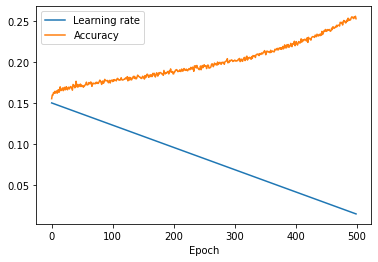

In [ ]:
plt.plot(stats['lr'], label = 'Learning rate')
plt.plot(stats['acc'], label = 'Accuracy')

plt.xlabel('Epoch')
plt.legend()
plt.show()

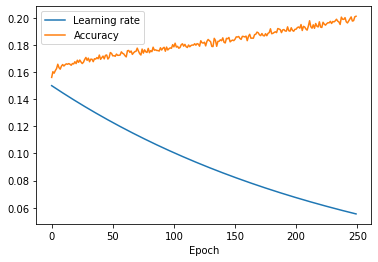

In [ ]:
plt.plot(stats['lr'], label = 'Learning rate')
plt.plot(stats['acc'], label = 'Accuracy')

plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
pred_lr = lr.predict(X_train_CIFAR)
print('The training accuracy of const is given by: %f' % (get_acc(pred_lr, y_train_CIFAR)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


The training accuracy of const is given by: 0.252525


In [ ]:
pred_lr = lr.predict(X_train_CIFAR)
print('The training accuracy is given by: %f' % (get_acc(pred_lr, y_train_CIFAR)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


The training accuracy is given by: 0.207675


In [ ]:
pred_lr = lr.predict(X_train_CIFAR)
print('The training accuracy is given by: %f' % (get_acc(pred_lr, y_train_CIFAR)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


The training accuracy is given by: 0.207200


### Validate Logistic Classifer

In [ ]:
pred_lr = lr.predict(X_val_CIFAR)
print('The validation accuracy is given by: %f' % (get_acc(pred_lr, y_val_CIFAR)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


The validation accuracy is given by: 0.192700


### Test Logistic Classifier

In [ ]:
pred_lr = lr.predict(X_test_CIFAR)
print('The testing accuracy is given by: %f' % (get_acc(pred_lr, y_test_CIFAR)))

lr

output_submission_csv('output/Logistic_submission_CIFAR.csv', lr.predict(X_test_CIFAR))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


The testing accuracy is given by: 0.196000


#Observations

My Logistic Regression is not overfitting the data, but I don't think my update rule is correct. 
I was able to get it to work using the perceptron update rule but I wasn't able to implement gradient backpropogation for an update rule. 
As a result, my accuracy is worse for logisitic regression than for perceptron.

